In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.2
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.6.2
keras.api._v2.keras 2.6.0


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [6]:
# 子类API
# Model类的介绍可以看下面
# https://tensorflow.google.cn/api_docs/python/tf/keras/Model
# 其实就是将原有面向过程的代码，改为面向对象
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        """定义模型的层次"""
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(1)
    
    def call(self, input):
        """完成模型的正向计算(搭建)，call是被build方法调用的"""
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output

model = WideDeepModel()
# 下面这种也可以，和model = WideDeepModel()是没有打印细节？
# model = keras.models.Sequential([
#     WideDeepModel(),
# ])
# build等价于调用call
# model(input_shape=(None, 8))
model.build(input_shape=(None, 8))
        
print(model.summary())
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(0.001))
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]

Model: "wide_deep_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  270       
_________________________________________________________________
dense_4 (Dense)              multiple                  930       
_________________________________________________________________
dense_5 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
history = model.fit(x_train_scaled, y_train,
                    validation_data = (x_valid_scaled, y_valid),
                    epochs = 100,
                    callbacks = callbacks)

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 1.3371 - val_loss: 0.8523
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.7515 - val_loss: 0.7848
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6988 - val_loss: 0.7408
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6617 - val_loss: 0.7045
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6327 - val_loss: 0.6767
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6086 - val_loss: 0.6544
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5879 - val_loss: 0.6306
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5714 - val_loss: 0.6115
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5551 - val_loss: 0.5965
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5428 - val_lo

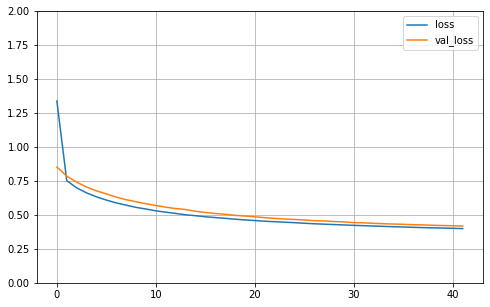

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 2)
    plt.show()
plot_learning_curves(history)

In [9]:
model.evaluate(x_test_scaled, y_test, verbose=0)

0.41641756892204285